# Analog: Ana(lyzing) Log(s)

## Parsing and Enriching Monthly Access Logs

Before we can analyze the web server access logs, we need to:

 1. Parse them to convert unstructured text into structured data;
 2. Add derrived columns that make analysis more straight-forward;
 3. Correlate some columns with other databases, notably for domain
    names, IP locations, and user agent classification.

To avoid reprocessing an ever growing amount of log data, we process each
monthly access log on its own, saving the resulting monthly dataframes as
individual Parquet files. We then combine all dataframes into a single one and
save that as a Parquet file, too. A JSON sidecar contains summary statistics.
That should let us get away with ingesting a new monthly access log each month.

Alas, during development of this library, bugs frequently required rebuilding
all monthly and the combined dataframes from scratch. By far the slowest step
when doing so are DNS lookups. For that reason, we cache all of their results,
which significantly speeds up the ingestion from several minutes down to a few
seconds.

In [1]:
from analog.__main__ import to_options
from analog.analyzer import calculate
from analog.data_manager import latest_log_data

# By default, latest_log_data() only logs errors and warnings.
# In verbose mode, it also logs informational messages.

VERBOSE = True

args = ["-v"] if VERBOSE else []

df, coverage = latest_log_data(to_options(args))
df.info(verbose=VERBOSE, memory_usage=True)

[INFO] Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[INFO] NumExpr defaulting to 8 threads.
[INFO] Running with configuration:
           root = /Users/rgrimm/Work/analog/data
          clean = False
    incremental = False
      use_color = None
         volume = 1
[INFO] Load existing log frame '/Users/rgrimm/Work/analog/data/apparebit.com-2018-07-2022-07.parquet'
[INFO] Validating log frame '/Users/rgrimm/Work/analog/data/apparebit.com-2018-07-2022-07.parquet'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227553 entries, 0 to 227552
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   client_address    227553 non-null  string             
 1   timestamp         227553 non-null  datetime64[ns, UTC]
 2   method            227553 non-null  category           
 3   path              227553 non-null  string             
 4   query             3226 non-null    string             
 5   protocol          227553 non-null  category           
 6   status            227553 non-null  int16              
 7   size              227553 non-null  int32              
 8   referrer          100860 non-null  string             
 9   user_agent        224065 non-null  string             
 10  server_name       202518 non-null  string             
 11  server_address    202518 non-null  string             
 12  content_type      227553 non-null  category 

## Monthly Page Views

[apparebit.com](https://apparebit.com) utilizes commercially licensed fonts.
Thankfully, all licenses are perpetual, i.e., don't require regular renewal and
hence repeated payment. However, they do impose upper limits on the number of
page views per month. So, let's calculate just that and then plot the result.

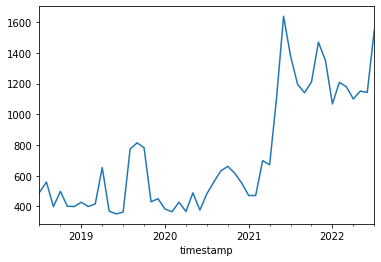

In [2]:
(
    calculate(df)     # Wrap dataframe for fluid filtering.
    .humans()          # Filter out requests by bots.
    .successfully()    # Filter out status codes other than 2xx.
    .getting()         # Filter out methods other than GET.
    .markup()          # Filter out resources other than HTML.
    .per_month()       # Count remaining requests per month.
    .then_plot()       # Plot a nice graph.
)